#Churn modelling
Classification Model

In [0]:
#import libraries
from pyspark.sql.functions import col, lower, lit, trim, when, size, countDistinct, datediff, to_date, to_timestamp, date_format, array_distinct
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np

# visualisation 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier

#evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


#cross validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# EDA

In [0]:
churn_df = (spark.table("feature_store_subeida.churn_modelling"))
churn_df_pd = churn_df.toPandas()
churn_df_pd_copy = churn_df_pd.copy()
churn_df_pd.head()

Out[2]:

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
churn_df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 RowNumber 10000 non-null int64 
 1 CustomerId 10000 non-null int64 
 2 Surname 10000 non-null object 
 3 CreditScore 10000 non-null int64 
 4 Geography 10000 non-null object 
 5 Gender 10000 non-null object 
 6 Age 10000 non-null int64 
 7 Tenure 10000 non-null int64 
 8 Balance 10000 non-null float64
 9 NumOfProducts 10000 non-null int64 
 10 HasCrCard 10000 non-null int64 
 11 IsActiveMember 10000 non-null int64 
 12 EstimatedSalary 10000 non-null float64
 13 Exited 10000 non-null int64 
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

In [0]:
#checking for missing values
churn_df_pd.isnull().sum()
#no missing values in df

Out[4]: RowNumber 0
CustomerId 0
Surname 0
CreditScore 0
Geography 0
Gender 0
Age 0
Tenure 0
Balance 0
NumOfProducts 0
HasCrCard 0
IsActiveMember 0
EstimatedSalary 0
Exited 0
dtype: int64

In [0]:
#dropping irrelevant columns
churn_df_pd = churn_df_pd.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [0]:
churn_df_pd["Exited"].value_counts(normalize = True)

#Baseline here is 79% of customers not churning, so want accuracy in model to beat this. 

Out[6]: 0 0.7963
1 0.2037
Name: Exited, dtype: float64

In [0]:
churn_df_pd.describe()

Out[7]:

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Out[8]:

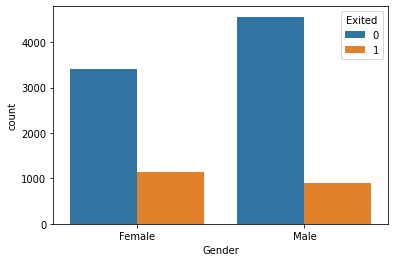

<AxesSubplot:xlabel='Gender', ylabel='count'>

In [0]:
sns.countplot(x="Gender", hue = "Exited", data=churn_df_pd)

Out[9]:

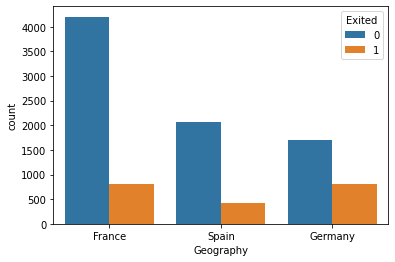

<AxesSubplot:xlabel='Geography', ylabel='count'>

In [0]:
sns.countplot(x="Geography",  hue = "Exited", data=churn_df_pd)

In [0]:
#checking the number of unique values for categorical variables
columns= ["Gender", "Geography"]
def col_summary(df, col_name):
    print(pd.DataFrame({col_name: df[col_name].value_counts()}))

for col in churn_df_pd[columns]:
    col_summary(churn_df_pd[columns], col)

Gender
Male 5457
Female 4543
 Geography
France 5014
Germany 2509
Spain 2477

#Data transformation

In [0]:
#Encoding/dummifying categorical variables
#Gender and Geography
churn_df_pd = pd.get_dummies(churn_df_pd)
churn_df_pd

#Note be careful when using .get_dummies before splitting data into x and y, because if the target variable is categorical it will split into 2 cols. 

Out[11]:

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


In [0]:
#prepping data for modelling
#train test split
X = churn_df_pd.drop(["Exited"], axis=1)
y = churn_df_pd["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [0]:
#standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Logistic regression model

In [0]:
lr=LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [0]:
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print()
print('Classification Report')
print(classification_report(y_test, y_pred))
print()
print('Accuracy of Model :',round(accuracy_score(y_test, y_pred),4))
#accuracy of the model is 78.1%...so lower than baseline...this is before standardisation
# now accuracy is 80.05, need to do hyperparamet tuning to try and get even higher. 

Confusion matrix:
[[1508 70]
 [ 329 93]]

Classification Report
 precision recall f1-score support

 0 0.82 0.96 0.88 1578
 1 0.57 0.22 0.32 422

 accuracy 0.80 2000
 macro avg 0.70 0.59 0.60 2000
weighted avg 0.77 0.80 0.76 2000


Accuracy of Model : 0.8005

In [0]:
#cross validation
lrscores = cross_val_score(lr, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', lrscores.mean())

Cross-Validation Accuracy Scores 0.812625

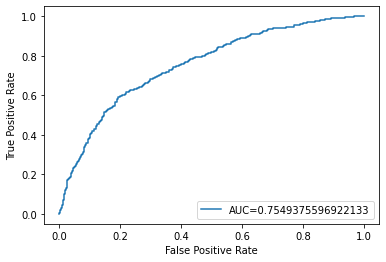

In [0]:
#ROC Curve/score
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#auc value 0.75. AUC score typically ranges from 0.5-1. The bigger the better the model is at classification.

#Random forrest

In [0]:
rf = RandomForestClassifier() #n_estimators = 100, max_depth = 10, random_state = 100
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [0]:
print("Confusion matrix:")
print(confusion_matrix(y_test,rf_y_pred))
print()
print('Classification Report')
print(classification_report(y_test, rf_y_pred))
print()
print('Accuracy of Model :',round(accuracy_score(y_test, rf_y_pred),4))
#rf is giving higher accuracy score compared to lr. 

Confusion matrix:
[[1511 67]
 [ 218 204]]

Classification Report
 precision recall f1-score support

 0 0.87 0.96 0.91 1578
 1 0.75 0.48 0.59 422

 accuracy 0.86 2000
 macro avg 0.81 0.72 0.75 2000
weighted avg 0.85 0.86 0.85 2000


Accuracy of Model : 0.8575

In [0]:
#cross validation
rfscores = cross_val_score(rf, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', rfscores.mean())

Cross-Validation Accuracy Scores 0.862125

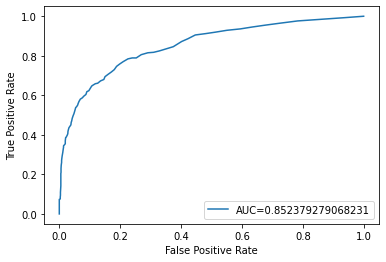

In [0]:
#ROC Curve/score
y_pred_proba_rf = rf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _rf = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba_rf)

#create ROC curve
plt.plot(fpr_rf,tpr_rf,label="AUC="+str(auc_rf))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#AUC score of 0.85, close to 1, means rf is better at classifying if cust will churn or not. 

#Feauture importance for LR and rf models

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. 
Feature importance can be investigated through model coefficients, decision trees and permutation testing. 
Linear machine learning algorithms fit a model where the prediction is the wieghted sum of input values. LR finds a set of coefficients to use in the weighted sum in order to make a prediction.
These coefficients can be used as a feature importance score.

Feature: 0, Score: -0.05311
Feature: 1, Score: 0.77249
Feature: 2, Score: -0.01765
Feature: 3, Score: 0.15016
Feature: 4, Score: -0.06511
Feature: 5, Score: -0.02500
Feature: 6, Score: -0.54569
Feature: 7, Score: 0.03781
Feature: 8, Score: -0.12414
Feature: 9, Score: 0.25723
Feature: 10, Score: -0.11406
Feature: 11, Score: 0.13641
Feature: 12, Score: -0.13641

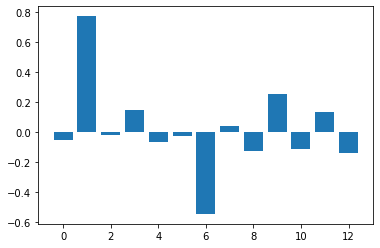

In [0]:
#coefficients/feature importance
#rf lack of directionality...
#plot a bar chart...
from matplotlib import pyplot
# logistic regression for feature importance
# get importance
importance = lr.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
#Notice the coeffecients are both positive and negative. Positive indicates a feature that predicts class 1, and negative scores indicate a feature that predicts class 0. 
#According to these results, features 1,3,9 and 11 have a posstiive effect on the predicted outcome. 

Feature: 0, Score: 0.14414
Feature: 1, Score: 0.23759
Feature: 2, Score: 0.08342
Feature: 3, Score: 0.14253
Feature: 4, Score: 0.12375
Feature: 5, Score: 0.01803
Feature: 6, Score: 0.04186
Feature: 7, Score: 0.14654
Feature: 8, Score: 0.00997
Feature: 9, Score: 0.02339
Feature: 10, Score: 0.00930
Feature: 11, Score: 0.00993
Feature: 12, Score: 0.00954

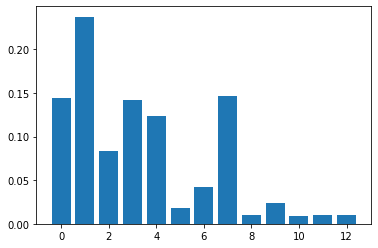

In [0]:
#RF coefficients...
importance_rf = rf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_rf):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance_rf))], importance_rf)
pyplot.show()

#Hyperparamater tuning for RF model

Hyperparameter fine tuning is an important step in ML, as it allows you to find the the best hyperparameters for your model. This can be done easily using GridSearchCV and Sklearn

In [0]:
#Logisitic regression has a lower performance to the random forest classifier, so will hypertune the parameters of the rf model to get a better accuracy score...
from sklearn.model_selection import GridSearchCV
#Chosen parameters to fine tune, n_estimators, criterion, max_features, and max_depth 

param_grid = {
    "n_estimators": [25,50,100,150],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [3,6,9]
}

grid_search = GridSearchCV(RandomForestClassifier(),
                            param_grid= param_grid)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features='log2',
 n_estimators=150)

In [0]:
#Now will run the model with the optimal parameters...
rf2 = RandomForestClassifier(criterion='entropy', 
                            max_depth=9, 
                            max_features='log2',
                            n_estimators=150

) #n_estimators = 100, max_depth = 10, random_state = 100
rf2.fit(X_train, y_train)
rf2_y_pred = rf2.predict(X_test)

In [0]:

print("Confusion matrix:")
print(confusion_matrix(y_test,rf2_y_pred))
print()
print('Classification Report')
print(classification_report(y_test, rf2_y_pred))
print()
print('Accuracy of Model :',round(accuracy_score(y_test, rf2_y_pred),4))
#hypertuning the parameters did not have much of an effect on the accuracy score...its still 86%
#but it does correctly identify more true postives....

Confusion matrix:
[[1532 46]
 [ 243 179]]

Classification Report
 precision recall f1-score support

 0 0.86 0.97 0.91 1578
 1 0.80 0.42 0.55 422

 accuracy 0.86 2000
 macro avg 0.83 0.70 0.73 2000
weighted avg 0.85 0.86 0.84 2000


Accuracy of Model : 0.8555